In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
from xgboost import XGBRegressor

In [2]:
myData = pd.read_csv('data/chongqing.csv')

In [3]:
## 1. check the data types in this data frame
myData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677 entries, 0 to 2676
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2677 non-null   int64  
 1   date           2677 non-null   object 
 2   X              2663 non-null   float64
 3   PM25           2655 non-null   float64
 4   PM10           2655 non-null   float64
 5   CO             2655 non-null   float64
 6   NO2            2655 non-null   float64
 7   SO2            2652 non-null   float64
 8   O3             2291 non-null   float64
 9   year           2677 non-null   int64  
 10  month          2677 non-null   int64  
 11  day            2677 non-null   int64  
 12  week           2677 non-null   int64  
 13  season         2663 non-null   object 
 14  covid          2663 non-null   object 
 15  city           2663 non-null   object 
 16  region         2663 non-null   object 
 17  avgtemp        2646 non-null   float64
 18  maxtemp 

In [4]:
## 2. identification and removal of outliers
myData.describe()

Unnamed: 0            X         PM25         PM10           CO  \
count  2677.000000  2663.000000  2655.000000  2655.000000  2655.000000   
mean   1339.000000  1333.000000    54.842347    86.979725   856.644068   
std     772.927659   768.886207    35.950181    49.159656   311.695051   
min       1.000000     2.000000     7.680000    13.320000    90.000000   
25%     670.000000   667.500000    32.210000    51.060000   630.000000   
50%    1339.000000  1333.000000    45.100000    75.000000   810.000000   
75%    2008.000000  1998.500000    66.900000   111.000000   990.000000   
max    2677.000000  2664.000000   249.500000   373.200000  3420.000000   

               NO2          SO2           O3         year        month  ...  \
count  2655.000000  2652.000000  2291.000000  2677.000000  2677.000000  ...   
mean     29.170501     5.437707    41.327564  2017.180052     6.342174  ...   
std       9.423119     4.357821    34.035063     2.123188     3.480705  ...   
min       5.400000     0.700000     1.250000  2014.000000     1.000000  ...   
25%      22.680000     2.800000    15.000000  2015.000000     3.000000  ...   
50%      28.080000     4.200000    30.000000  2017.000000     6.000000  ...   
75%      34.560000     6.300000    58.750000  2019.000000     9.000000  ...   
max      77.000000    41.400000   187.400000  2021.000000    12.000000  ...   

         extremews  extremewswd     daylight  precipitation           avgp  \
count  2647.000000  2647.000000  2647.000000    2632.000000    2646.000000   
mean      4.923158    10.202493     2.792671       3.548404   98345.207861   
std       2.129013     5.208265     3.867556       9.688665     856.631826   
min       2.000000     1.000000     0.000000       0.000000   96260.000000   
25%       3.500000     5.000000     0.000000       0.000000   97610.000000   
50%       4.400000    11.000000     0.000000       0.000000   98360.000000   
75%       5.700000    15.000000     5.500000       2.000000   99020.000000   
max      34.900000    16.000000    12.800000     111.200000  101230.000000   

                maxp           minp        avggt        maxgt        mingt  
count    2647.000000    2647.000000  2641.000000  2647.000000  2647.000000  
mean    98593.819418   98027.684171    20.559447    31.307140    15.646317  
std       891.722260     842.558934     9.007856    14.682322     7.178454  
min     96630.000000   95790.000000     2.500000     6.200000    -1.100000  
25%     97825.000000   97300.000000    12.400000    19.800000     9.600000  
50%     98610.000000   98030.000000    20.000000    28.600000    16.000000  
75%     99280.000000   98690.000000    26.600000    40.900000    21.600000  
max    101560.000000  100960.000000    43.800000    75.000000    31.700000  

[8 rows x 30 columns]

In [5]:
## 3. missing values
myData[myData.isnull().T.any()] ## rows contain empty values -- can be from one or multiple columns

Unnamed: 0       date       X    PM25    PM10      CO    NO2   SO2  \
0              1   2014/1/1     2.0  139.10  193.00  1350.0  24.84  27.3   
1              2   2014/1/2     3.0  159.50  241.00  1530.0  32.40  28.7   
2              3   2014/1/3     4.0  178.50  255.00  1710.0  38.88  21.0   
3              4   2014/1/4     5.0  189.50  213.00  1350.0  27.00  16.1   
4              5   2014/1/5     6.0  169.50  203.00  1620.0  25.92  15.4   
...          ...        ...     ...     ...     ...     ...    ...   ...   
2661        2662  2021/4/15  2649.0   36.30   42.18   810.0  24.84   2.8   
2665        2666  2021/4/19  2653.0   26.10   43.29   900.0  25.92   0.7   
2667        2668  2021/4/21  2655.0   35.90   59.00   810.0  27.00   2.8   
2673        2674  2021/4/27  2661.0   25.16   77.00   540.0  25.92   3.5   
2675        2676  2021/4/29  2663.0   27.51   71.00   630.0  39.96   3.5   

          O3  year  ...  extremews  extremewswd  daylight precipitation  \
0        NaN  2014  ...        3.3         16.0       0.0           0.0   
1        NaN  2014  ...        3.2         16.0       0.0           0.0   
2        NaN  2014  ...        2.5         14.0       0.0           0.0   
3        NaN  2014  ...        2.9         14.0       0.0           0.0   
4        NaN  2014  ...        2.4         14.0       0.0           0.0   
...      ...   ...  ...        ...          ...       ...           ...   
2661   16.25  2021  ...        5.5         15.0       0.0           NaN   
2665   12.50  2021  ...        4.7          1.0       0.0           NaN   
2667   50.00  2021  ...        3.0          8.0       3.5           NaN   
2673   22.50  2021  ...        4.6         15.0       7.8           NaN   
2675  108.75  2021  ...        5.2         10.0      11.6           NaN   

         avgp     maxp     minp  avggt  maxgt  mingt  
0     99080.0  99490.0  98630.0    5.1    8.1    1.2  
1     98920.0  99150.0  98700.0    6.6    9.6    5.1  
2     99400.0  99660.0  99080.0    8.9   18.4    4.7  
3     99290.0  99700.0  98780.0    8.0   18.9    2.0  
4     98490.0  98830.0  98270.0    6.2    8.7    2.7  
...       ...      ...      ...    ...    ...    ...  
2661  98360.0  98490.0  98200.0   18.3   22.4   16.2  
2665  98040.0  98500.0  97610.0   18.6   25.4   15.3  
2667  98000.0  98220.0  97810.0   22.1   35.1   16.9  
2673  98540.0  98800.0  98130.0   25.0   41.7   17.3  
2675  98420.0  99080.0  97740.0   26.1   43.8   14.6  

[448 rows x 35 columns]

In [6]:
myData = myData[~myData.isnull().T.any()] ## remove all rows that contains at least one Nan values
## the symbol ~ means opposite operations, .T means transpose, .isna() and .isnull() are the same

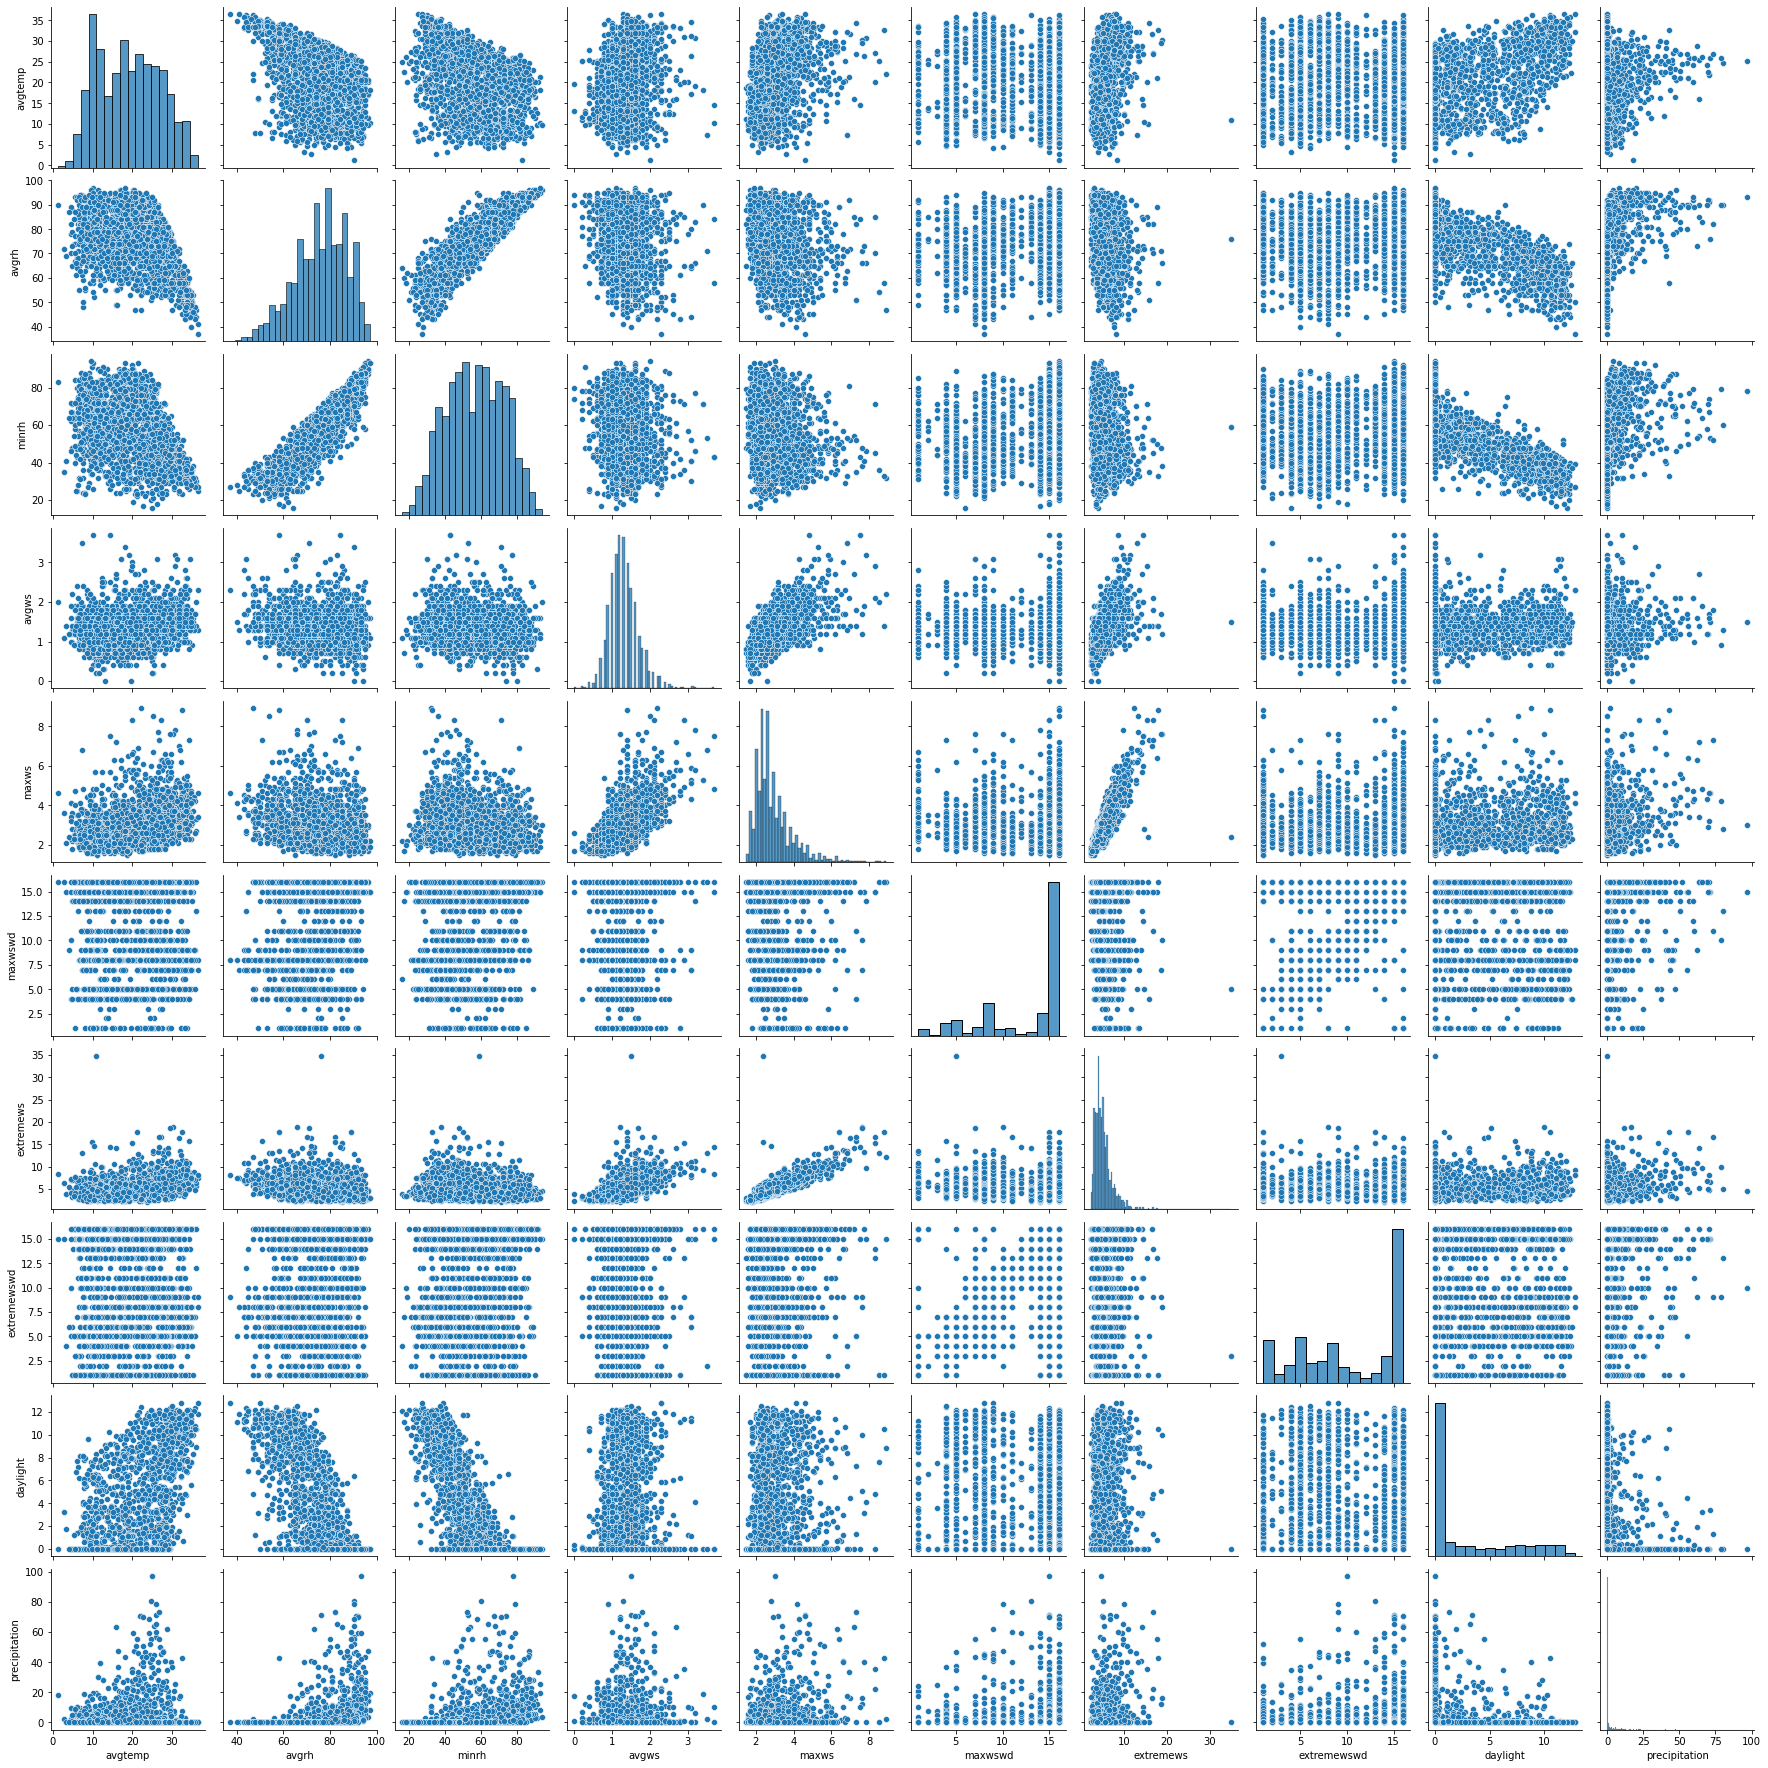

In [7]:
## 5. check colinearity
selected_continuous_variables =  ['avgtemp', 'avgrh', 'minrh', 'avgws', 'maxws',
       'maxwswd', 'extremews', 'extremewswd', 'daylight', 'precipitation']
sns.pairplot(myData[selected_continuous_variables])

In [8]:
## 6. variable transformation
# this step is also optional
# most variables are normal or normal-like distributed except for ['minrh', 'avgws', 'extremews', 'precipitation']
# we can perform some log transformation to make every variable look normal since this is preferred or assumed by
# most statistical or Machine learning models.
cols_to_transform = ['minrh', 'avgws', 'extremews', 'precipitation']
for col in cols_to_transform:
    myData[col] = np.log(1+myData[col])
# replot the pairwise colinearity chart
#sns.pairplot(myData[selected_continuous_variables])
## now every thing looks more normally distributed...

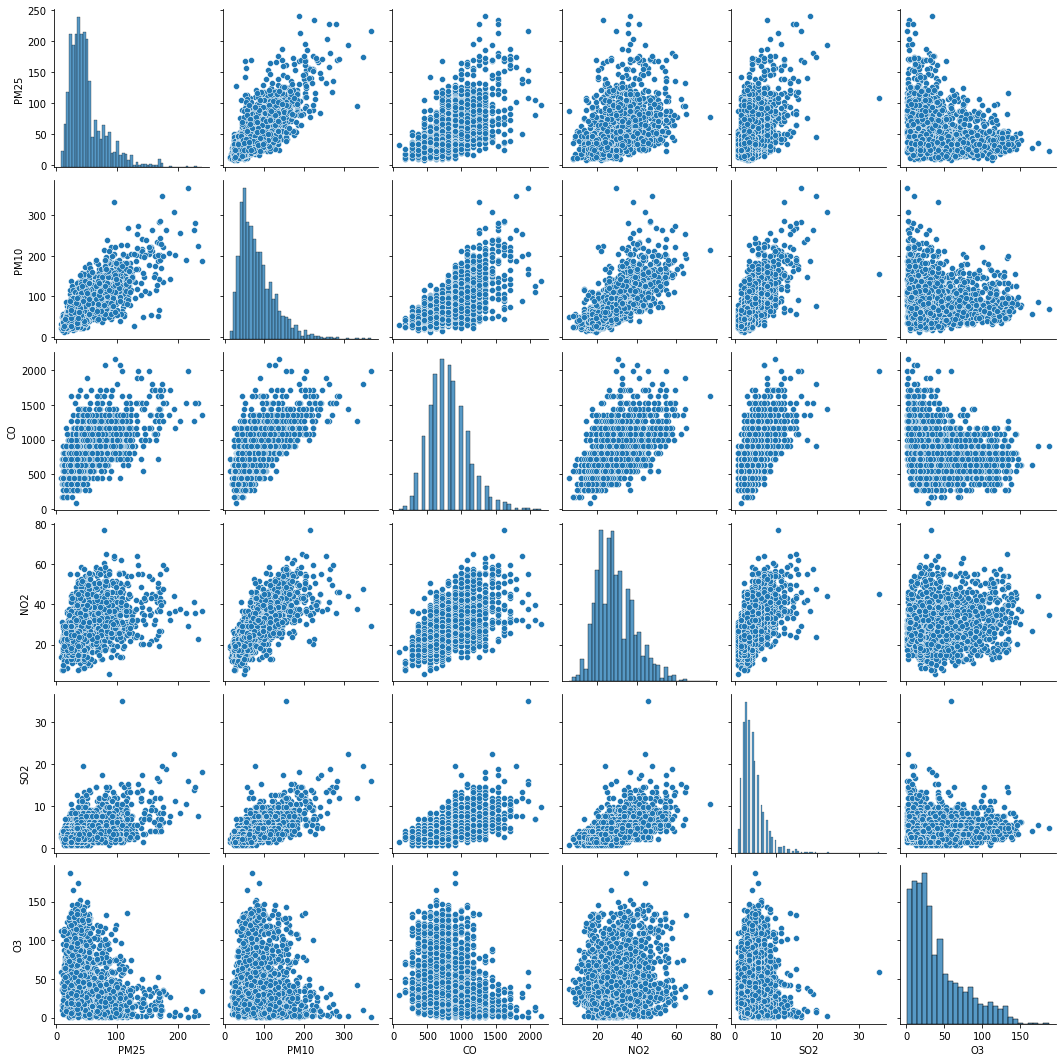

In [9]:
sns.pairplot(myData[['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']])

In [10]:
Y = myData[['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']].apply(lambda x: np.log(1+x)) ## perform similar transformation to Y's
#Y = myData[['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']]

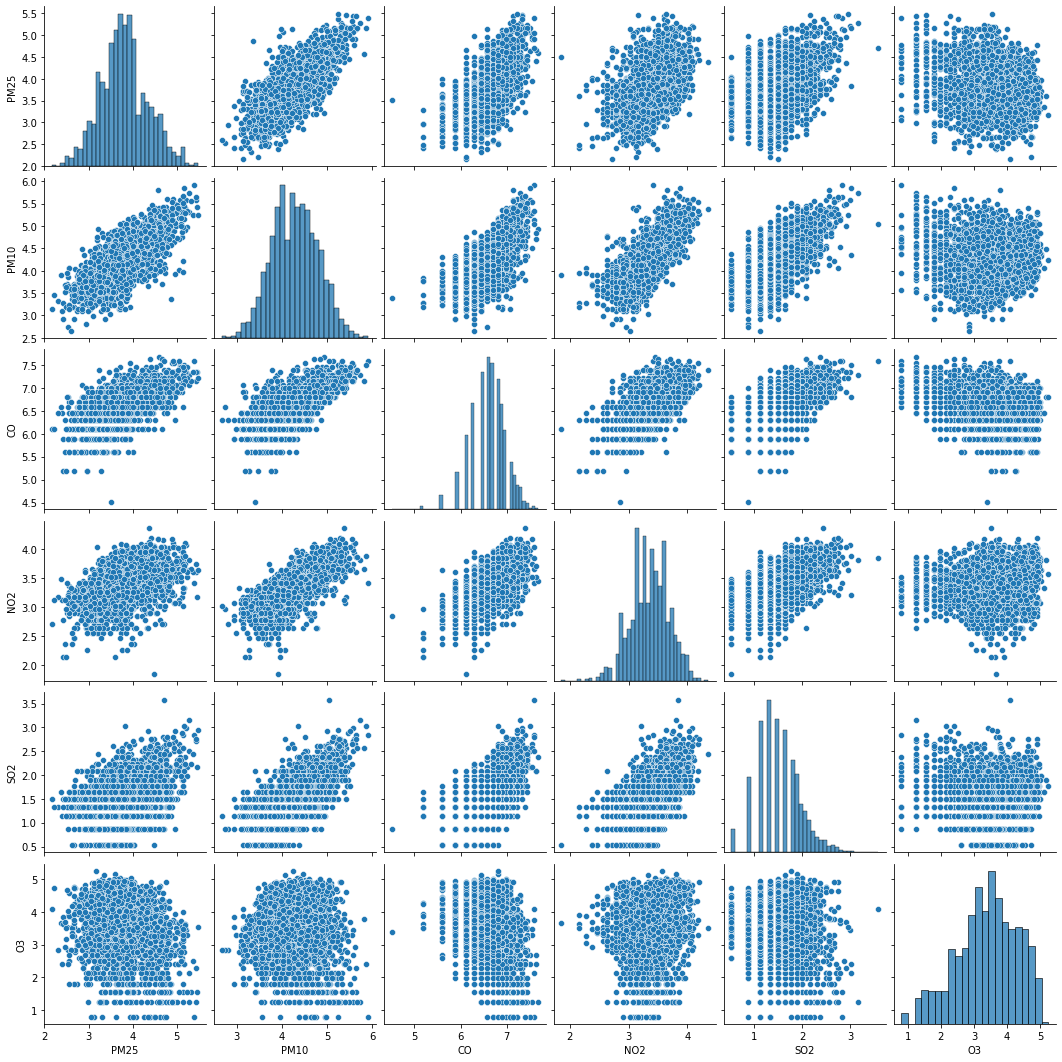

In [11]:
sns.pairplot(Y)

In [12]:
## 7. treating the time series variables
categorical_variables = ['year', 'month', 'day', 'week', 'season']
myData.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [13]:
def parse_time_string_dow(time_string):
    date_time_obj = datetime.strptime(str(time_string).split(".")[0], '%Y-%m-%d')
    dow = date_time_obj.weekday()
    return dow
## converting all days to weekdays which makes more sense
myData['weekday'] = myData.apply(lambda x: parse_time_string_dow(str(x['year'])+"-"+str(x['month'])+'-'+str(x['day'])), axis=1)
# string concatenation of the first three columns -> 2014-1-1, then use the parse time string function to convert
# a specific date to weekday, i.e., Mon, Tue, Wed, etc.

In [14]:
## usually the way to treat the categorical variables are to convert them to category levels (e.g., 0,1,2), which 
#  called ordinal encoding (categories have orders); or to convert them into one-hot categories (more popular) e.g.
# winter 
#         spring
#                 summer
#                        fall
# In the above matrix, every category is treated equally.

# The variable 'week' has 52 categories, which will cause super sparse matrix, so we discard it. Don't worry, the info 
# can be captured by other variables since these are very correlated variables.

X_categorical = myData[['year', 'month', 'weekday', 'season']]
X_continuous = myData[selected_continuous_variables]

In [15]:
## convert all X_categorical to strings so we can simply make them to category levels - if not, pandas will still 
# believe they are numerical values.
X_categorical = pd.concat([myData['year'].apply(str),myData['month'].apply(str),
                          myData['weekday'].apply(str), myData['season']], axis=1)
X_categorical

year month weekday  season
367   2015     1       5  winter
368   2015     1       6  winter
369   2015     1       0  winter
370   2015     1       1  winter
371   2015     1       2  winter
...    ...   ...     ...     ...
2670  2021     4       5  spring
2671  2021     4       6  spring
2672  2021     4       0  spring
2674  2021     4       2  spring
2676  2021     4       4  spring

[2229 rows x 4 columns]

In [16]:
X_categorical = pd.get_dummies(X_categorical, drop_first=True) ## dropping a random one to aviod colinearity

In [17]:
## now we can concatenate both the categorical and the continuous variables together
X = pd.concat([X_categorical, X_continuous], axis=1)

In [18]:
## 8. standardize all the X variables to stablize the model fitting
#     since some methods are value scale sensitive
scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [19]:
myData.reset_index(inplace=True, drop=True) ## unifiying the myData and X's index systems...

In [20]:
Y.reset_index(inplace=True, drop=True)

In [21]:
## try using 2014-2017 as training, 2018 as testing -- and then try 2014-2018 training, 2019 testing

X_pre_2017 = X.loc[(myData.loc[:,'year'] <= 2017) & (myData.loc[:,'year'] >= 2016),:]
X_2018 = X.loc[myData.loc[:,'year'] == 2018,:]
X_pre_2018 = X.loc[(myData.loc[:,'year'] <= 2018) & (myData.loc[:,'year'] >= 2017),:]
X_2019 = X.loc[myData.loc[:,'year'] == 2019,:]
X_pre_2019 = X.loc[(myData.loc[:,'year'] <= 2019) & (myData.loc[:,'year'] >= 2018),:]
X_2020 = X.loc[myData.loc[:,'year'] == 2020,:]
X_covid = X.loc[(myData.loc[:,'year'] == 2020) & (myData.loc[:,'covid'] == '2.ing'),:]

Y_pre_2017 = Y.loc[(myData.loc[:,'year'] <= 2017) & (myData.loc[:,'year'] >= 2016),:]
Y_2018 = Y.loc[myData.loc[:,'year'] == 2018,:]
Y_pre_2018 = Y.loc[(myData.loc[:,'year'] <= 2018) & (myData.loc[:,'year'] >= 2017),:]
Y_2019 = Y.loc[myData.loc[:,'year'] == 2019,:]
Y_pre_2019 = Y.loc[(myData.loc[:,'year'] <= 2019) & (myData.loc[:,'year'] >= 2018),:]
Y_2020 = Y.loc[myData.loc[:,'year'] == 2020,:]

Y_covid = Y.loc[(myData.loc[:,'year'] == 2020) & (myData.loc[:,'covid'] == '2.ing'),:]

## merge X Y
xy = pd.concat([Y, X], axis = 1) # for later use

In [22]:
## regression model evaluation metrics
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [23]:
## now lets pull out same results for all the six responses
responses = ['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']

param_grid = [
            {'n_estimators': [60,80,100,120,160,200], 'max_features': [6,12,18,24]},
    ]
acc = {2018:{},2019:{},2020:{}}
with open('results/'+"2019_predictive_accuracies.txt","w+") as fp:
    for response in responses:
        #regr = RandomForestRegressor()
        regr = XGBRegressor()
        grid_search =  GridSearchCV(regr,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
        grid_search.fit(X_pre_2018,Y_pre_2018[response])
        print(grid_search.best_params_)
        training_acc = evaluate(grid_search.best_estimator_, X_pre_2018,Y_pre_2018[response])
        testing_acc = evaluate(grid_search.best_estimator_, X_2019,Y_2019[response])
        acc[2019][response] = testing_acc
        Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)
        fp.write(str(response)+" eval training accuracy: "+str(training_acc)+"\n")
        fp.write(str(response)+" eval test accuracy: "+str(testing_acc)+"\n")
fp.close()

pd.concat([Y_2019,X_2019], axis=1).to_csv('results/'+"predicted-2019.csv", index=False)

[16:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-23-c108fa6f4b5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)


[16:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-23-c108fa6f4b5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)


[16:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-23-c108fa6f4b5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)


[16:23:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:23:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-23-c108fa6f4b5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)



[16:23:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-23-c108fa6f4b5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)



[16:24:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-23-c108fa6f4b5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2019["predicted_"+response] = grid_search.best_estimator_.predict(X_2019)


In [24]:
responses = ['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']

param_grid = [
            {'n_estimators': [60,80,100,120,160,200], 'max_features': [6,12,18,24]},
    ]
with open('results/'+"2018_predictive_accuracies.txt","w+") as fp:
    for response in responses:
        #regr = RandomForestRegressor()
        regr = XGBRegressor()
        grid_search =  GridSearchCV(regr,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
        grid_search.fit(X_pre_2017,Y_pre_2017[response])
        print(grid_search.best_params_)
        training_acc = evaluate(grid_search.best_estimator_, X_pre_2017,Y_pre_2017[response])
        testing_acc = evaluate(grid_search.best_estimator_, X_2018,Y_2018[response])
        acc[2018][response] = testing_acc
        Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)
        
        fp.write(str(response)+" eval training accuracy: "+str(training_acc)+"\n")
        fp.write(str(response)+" eval test accuracy: "+str(testing_acc)+"\n")
fp.close()

pd.concat([Y_2018,X_2018], axis=1).to_csv('results/'+"predicted-2018.csv", index=False)

[16:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-24-f3fd477b023f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)



[16:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:24:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:24:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-24-f3fd477b023f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)


[16:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:25:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:25:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:25:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-24-f3fd477b023f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)


[16:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-24-f3fd477b023f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)


[16:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:25:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:25:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:25:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-24-f3fd477b023f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)



[16:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-24-f3fd477b023f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2018["predicted_"+response] = grid_search.best_estimator_.predict(X_2018)


In [25]:
responses = ['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']

param_grid = [
            {'n_estimators': [60,80,100,120,160,200], 'max_features': [6,12,18,24]},
    ]
with open('results/'+"2020_predictive_accuracies.txt","w+") as fp:
    for response in responses:
        #regr = RandomForestRegressor()
        regr = XGBRegressor()
        grid_search =  GridSearchCV(regr,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
        grid_search.fit(X_pre_2019,Y_pre_2019[response])
        print(grid_search.best_params_)
        training_acc = evaluate(grid_search.best_estimator_, X_pre_2019,Y_pre_2019[response])
        testing_acc = evaluate(grid_search.best_estimator_, X_2020,Y_2020[response])
        acc[2020][response] = testing_acc
        Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)
        
        fp.write(str(response)+" eval training accuracy: "+str(training_acc)+"\n")
        fp.write(str(response)+" eval test accuracy: "+str(testing_acc)+"\n")
fp.close()

pd.concat([Y_2020,X_2020], axis=1).to_csv('results/'+"predicted-2020.csv", index=False)

[16:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:26:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-25-083d6c8a95c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)



[16:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:26:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:26:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:26:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-25-083d6c8a95c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)



[16:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:27:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-25-083d6c8a95c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)



[16:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-25-083d6c8a95c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)



[16:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:27:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

<ipython-input-25-083d6c8a95c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)


[16:27:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-25-083d6c8a95c6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_2020["predicted_"+response] = grid_search.best_estimator_.predict(X_2020)


In [26]:
acc

{2018: {'PM25': 89.32646459759565,
  'PM10': 90.2946706945541,
  'CO': 96.57422906354279,
  'NO2': 91.98683670001198,
  'SO2': 77.89635786626573,
  'O3': 83.4862325925468},
 2019: {'PM25': 91.53300191969385,
  'PM10': 92.74799477166347,
  'CO': 96.79640378327079,
  'NO2': 94.05230706356308,
  'SO2': 58.55320019674637,
  'O3': 83.15551940610871},
 2020: {'PM25': 91.5073166817663,
  'PM10': 93.01446729933839,
  'CO': 94.98635179518529,
  'NO2': 91.97512233478861,
  'SO2': 74.60995695599446,
  'O3': 81.92708358250128}}

In [27]:
responses = ['PM25', 'PM10', 'CO', 'NO2', 'SO2','O3']

param_grid = [            {'n_estimators': [60,80,100,120,160,200], 'max_features': [6,12,18,24]},
    ]
with open('results/'+"2020_predictive_accuracies.txt","w+") as fp:
    for response in responses:
        #regr = RandomForestRegressor()
        regr = XGBRegressor()
        grid_search =  GridSearchCV(regr,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
        grid_search.fit(X_pre_2019,Y_pre_2019[response])
        print(grid_search.best_params_)
        training_acc = evaluate(grid_search.best_estimator_, X_pre_2019,Y_pre_2019[response])
        testing_acc = evaluate(grid_search.best_estimator_, X_covid,Y_covid[response])
        #acc[2020][response] = testing_acc
        Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
        Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
        Y_covid[response+"_real"] = np.exp(Y_covid[response] - 1)
        fp.write(str(response)+" eval training accuracy: "+str(training_acc)+"\n")
        fp.write(str(response)+" eval test accuracy: "+str(testing_acc)+"\n")
fp.close()

pd.concat([Y_covid,X_covid], axis=1).to_csv('results/'+"predicted-covid.csv", index=False)

[16:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-27-92f05b42cfb8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
<ipython-input-27-92f05b42cfb8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
<ipython-input-27-92f05b42cfb8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

[16:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-27-92f05b42cfb8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
<ipython-input-27-92f05b42cfb8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
<ipython-input-27-92f05b42cfb8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

[16:28:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

<ipython-input-27-92f05b42cfb8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
<ipython-input-27-92f05b42cfb8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
<ipython-input-27-92f05b42cfb8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S


[16:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use


[16:29:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-27-92f05b42cfb8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
<ipython-input-27-92f05b42cfb8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
<ipython-input-27-92f05b42cfb8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S


[16:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-27-92f05b42cfb8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
<ipython-input-27-92f05b42cfb8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
<ipython-input-27-92f05b42cfb8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

[16:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used


[16:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only use

[16:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

[16:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used

<ipython-input-27-92f05b42cfb8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid["predicted_"+response] = grid_search.best_estimator_.predict(X_covid)
<ipython-input-27-92f05b42cfb8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_covid['Predicted_'+response+"_real"] = np.exp(Y_covid["predicted_"+response] - 1)
<ipython-input-27-92f05b42cfb8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [28]:
np.std(Y_covid["Predicted_PM25_real"]) 

8.51732349395752

In [29]:
Y_covid.mean(axis=0)

PM25                     3.882283
PM10                     4.195668
CO                       6.434189
NO2                      2.919825
SO2                      1.132261
O3                       3.534659
predicted_PM25           3.984416
Predicted_PM25_real     21.309694
PM25_real               18.729049
predicted_PM10           4.393437
Predicted_PM10_real     31.214705
PM10_real               25.623294
predicted_CO             6.678611
Predicted_CO_real      296.831879
CO_real                235.994662
predicted_NO2            3.313435
Predicted_NO2_real      10.368890
NO2_real                 7.300935
predicted_SO2            1.428155
Predicted_SO2_real       1.588514
SO2_real                 1.196221
predicted_O3             3.220544
Predicted_O3_real       10.379304
O3_real                 14.017740
dtype: float64

In [30]:
Y_covid.sem(axis=0)

PM25                   0.039402
PM10                   0.041014
CO                     0.032645
NO2                    0.048614
SO2                    0.039667
O3                     0.057900
predicted_PM25         0.050161
Predicted_PM25_real    1.108861
PM25_real              0.802245
predicted_PM10         0.041618
Predicted_PM10_real    1.186166
PM10_real              1.012664
predicted_CO           0.022603
Predicted_CO_real      6.398618
CO_real                7.130351
predicted_NO2          0.028932
Predicted_NO2_real     0.316205
NO2_real               0.355167
predicted_SO2          0.034691
Predicted_SO2_real     0.053719
SO2_real               0.049383
predicted_O3           0.061986
Predicted_O3_real      0.755542
O3_real                0.933014
dtype: float64

In [31]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'ppbv')

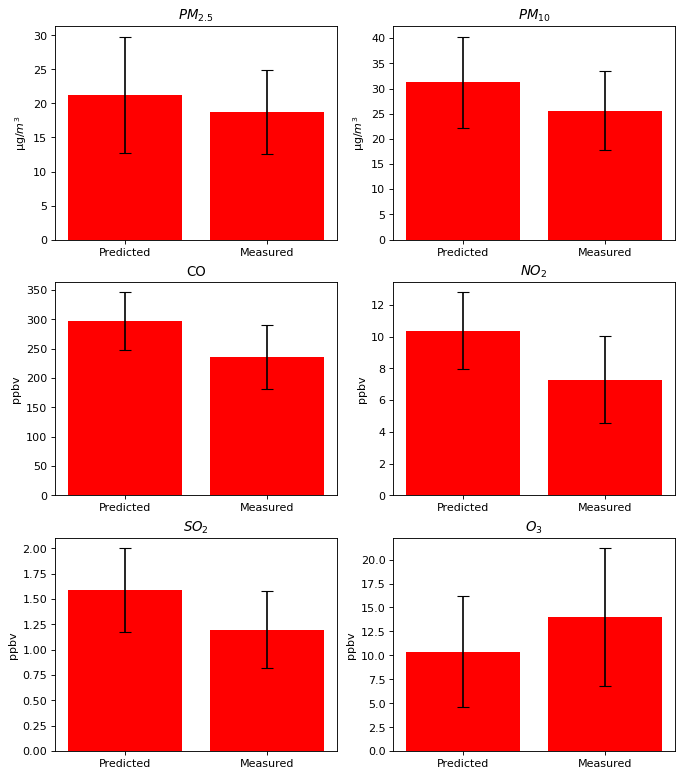

In [32]:
f, axes = plt.subplots(3, 2, figsize=(10,12), dpi=80, facecolor='w', edgecolor='k')
errorPM25= [np.std(Y_covid["Predicted_PM25_real"]),np.std(Y_covid["PM25_real"])]
axes[0, 0].bar(["Predicted","Measured"],[np.mean(Y_covid["Predicted_PM25_real"]),np.mean(Y_covid["PM25_real"])],color='r',
       yerr=errorPM25,
       align='center',
       ecolor='black',
       capsize=5)
axes[0, 0].set_title('$PM_{2.5}$')
axes[0, 0].set_ylabel('μg/$m^3$')
errorPM10= [np.std(Y_covid["Predicted_PM10_real"]),np.std(Y_covid["PM10_real"])]
axes[0, 1].bar(["Predicted","Measured"],[np.mean(Y_covid["Predicted_PM10_real"]),np.mean(Y_covid["PM10_real"])],color='r',
       yerr=errorPM10,
       align='center',
       ecolor='black',
       capsize=5)
errorCO= [np.std(Y_covid["Predicted_CO_real"]),np.std(Y_covid["CO_real"])]
axes[0, 1].set_title('$PM_{10}$')
axes[0, 1].set_ylabel('μg/$m^3$')
axes[1, 0].bar(["Predicted","Measured"],[np.mean(Y_covid["Predicted_CO_real"]),np.mean(Y_covid["CO_real"])],color='r',
       yerr=errorCO,
       align='center',
       ecolor='black',
       capsize=5)
axes[1, 0].set_title('CO')
axes[1, 0].set_ylabel('ppbv')
errorNO2= [np.std(Y_covid["Predicted_NO2_real"]),np.std(Y_covid["NO2_real"])]
axes[1, 1].bar(["Predicted","Measured"],[np.mean(Y_covid["Predicted_NO2_real"]),np.mean(Y_covid["NO2_real"])],color='r',
       yerr=errorNO2,
       align='center',
       ecolor='black',
       capsize=5)
axes[1, 1].set_title('$NO_{2}$')
axes[1, 1].set_ylabel('ppbv')
errorSO2= [np.std(Y_covid["Predicted_SO2_real"]),np.std(Y_covid["SO2_real"])]
axes[2, 0].bar(["Predicted","Measured"],[np.mean(Y_covid["Predicted_SO2_real"]),np.mean(Y_covid["SO2_real"])],color='r',
       yerr=errorSO2,
       align='center',
       ecolor='black',
       capsize=5)
axes[2, 0].set_title('$SO_{2}$')
axes[2, 0].set_ylabel('ppbv')
errorO3= [np.std(Y_covid["Predicted_O3_real"]),np.std(Y_covid["O3_real"])]
axes[2, 1].bar(["Predicted","Measured"],[np.mean(Y_covid["Predicted_O3_real"]),np.mean(Y_covid["O3_real"])],color='r',
       yerr=errorO3,
       align='center',
       ecolor='black',
       capsize=5)
axes[2, 1].set_title('$O_{3}$')
axes[2, 1].set_ylabel('ppbv')

In [33]:
f.savefig('results/'+'COVID_compar.png')